### In this notebook, we will forecast the CAQI levels from Jan to Feb 2022 for Warsaw, the capital of Poland. 

In [1]:
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from tqdm.auto import tqdm

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
train = pd.read_parquet("train_temporal_regression.parquet.gz")
test = pd.read_parquet("test_temporal_regression.parquet.gz")

#Combining to create whole dataset
full_df = pd.concat([train, test])

# Preparing Forecasting dataset

In [3]:
forecast_df = full_df.query("year==2021 and month in (1, 2)")

In [4]:
forecast_df.index = [pd.to_datetime(str(ix).replace("2021", "2022")) for ix in forecast_df.index]

In [5]:
forecast_df['year'] = forecast_df.index.year
forecast_df['dayofweek'] = forecast_df.index.dayofweek

In [6]:
forecast_df['is_weekend'] = np.where(forecast_df['dayofweek'].isin([5, 6]), 1, 0)

In [7]:
exclude_cols = [
    'powiat_voivod', 'voivodship', 'isUrban', 'day', 'month', 'year', 'dayofweek', 'season', 
    'is_lockdown', 'is_have_coalplant', 'is_weekend', 'holiday_name'
]

forecast_df[[col for col in forecast_df.columns if col not in exclude_cols]] = np.nan

### School holidays

In [8]:
voivod_dict = {
    'Greater Poland':'wielkopolskie', 
    'Kuyavia-Pomerania':'kujawsko-pomorskie', 
    'Lesser Poland':'małopolskie',
    'Lower Silesia':'dolnośląskie', 
    'Lublin':'lubelskie', 
    'Lubusz':'lubuskie', 
    'Mazovia':'mazowieckie', 
    'Opole':'opolskie',
    'Podkarpackie':'podkarpackie', 
    'Podlaskie':'podlaskie', 
    'Pomerania':'pomorskie', 
    'Silesian':'śląskie',
    'Warmian-Masuria':'warmińsko-mazurskie', 
    'West Pomerania':'zachodniopomorskie', 
    'Łódź':'łódzkie', 
    'Świętokrzyskie':'świętokrzyskie'
}

In [9]:
school_hol_df=\
pd.read_html("https://www.holidays-info.com/poland/school-holidays/2022/")[0].\
    rename(columns={"Unnamed: 0" : "voivod"})

In [10]:
school_hol_df['Winter']=\
school_hol_df['Winter'].str.split(" - ").str[0] + ", 2022" + " - " + \
school_hol_df['Winter'].str.split(" - ").str[1] + ", 2022"

In [11]:
for k, v in voivod_dict.items():
    for date in school_hol_df.query(f"voivod=='{k}'")['Winter']:

        start = date.split(" - ")[0]
        end = date.split(" - ")[1]

        daterange = pd.date_range(start, end, freq='D')

        forecast_df.loc[
            forecast_df['voivodship'].eq(v) & forecast_df.index.isin(daterange), 
            "is_school_holiday"
        ] = 1

In [12]:
forecast_df['is_school_holiday'] = forecast_df['is_school_holiday'].fillna(0)

In [13]:
forecast_df['is_school_holiday'].unique()

array([0., 1.])

# Merging to make wholedataset

In [14]:
full_future_df = pd.concat([full_df, forecast_df])

In [15]:
static_cols=\
list(
    full_future_df.loc[
        :, 'animal stock - total' : 'crop production - permanent pastures, area in ha, total'
    ].columns
)

#### Extrapolating static cols

In [16]:
#https://stackoverflow.com/a/68579584/15937542

full_future_df.loc["2022-01-01" : , static_cols]=\
full_future_df[["powiat_voivod"] + static_cols].groupby("powiat_voivod").\
    transform(lambda x: x.interpolate(method="slinear", fill_value="extrapolate")).\
    loc["2022-01-01" : ]

# Warsaw weather data

In [17]:
weather_df = \
pd.read_csv("datasets/Combined_weather_data_forecasting.csv", parse_dates=['DATE'], index_col='DATE').\
    drop("Unnamed: 0", axis=1).loc[:"2022-02-28"]

weather_df.head()

,cloud_cover,Q_cloud_cover,humidity,Q_humidity,precipitation,Q_precipitation,snow_depth,Q_snow_depth,temperature,Q_temperature,wind_speed,Q_wind_speed,powiat_voivod
DATE,,,,,,,,,,,,,
2022-01-01,7,0,86,0,0,0,0,0,7.9,0,33,0,"powiat warszawa, mazowieckie"
2022-01-02,7,0,89,0,5,0,0,0,6.8,0,37,0,"powiat warszawa, mazowieckie"
2022-01-03,6,0,85,0,43,0,0,0,7.9,0,47,0,"powiat warszawa, mazowieckie"
2022-01-04,6,0,93,0,35,0,0,0,6.2,0,17,0,"powiat warszawa, mazowieckie"
2022-01-05,7,0,91,0,25,0,0,0,4.2,0,27,0,"powiat warszawa, mazowieckie"


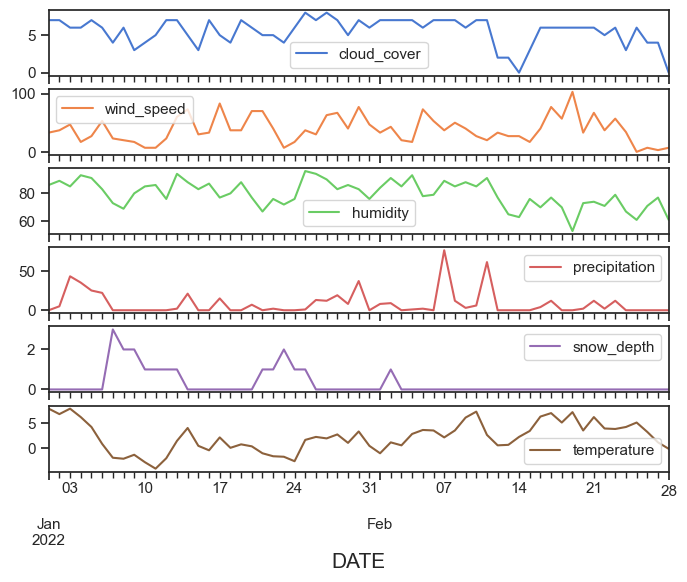

In [18]:
weather_cols=['cloud_cover', 'wind_speed', 'humidity', 'precipitation', 'snow_depth', 'temperature']

weather_df[weather_cols].plot(subplots=True, figsize=(8, 6));

In [19]:
warsaw_df=full_future_df.query("powiat_voivod=='powiat warszawa, mazowieckie'")

In [20]:
warsaw_df.loc["2022-01-01" : , weather_cols] = weather_df[weather_cols]

In [21]:
warsaw_df[["rolling90_CAQI", "rolling7_CAQI"]] = warsaw_df[["rolling90_CAQI", "rolling7_CAQI"]].fillna(0)

In [22]:
#Removing all other dataset
del weather_df, train, test, full_df, full_future_df

# Forecasting

In [23]:
#Trained XGboost pipeline
with open("final_model.pkl", "rb") as r:
    model = pickle.load(r)

For each date, we will need the lag1 CAQI value and rolling 30day mean CAQI value. The prediction will be done iteratively.

In [24]:
for date in tqdm(pd.date_range("2022-01-01", "2022-02-28")): 
    
    #Lag1 CAQI_idx
    warsaw_df.loc[date, "CAQI_lag1"] = warsaw_df.loc[pd.to_datetime(date)-pd.offsets.Day(1), 'CAQI_idx']
    
    #30day rolling mean
    warsaw_df.loc[date, "rolling30_CAQI"]=\
    warsaw_df.loc[
        pd.to_datetime(date)-pd.offsets.Day(30) : pd.to_datetime(date)-pd.offsets.Day(1), 'CAQI_idx'
    ].mean()
    
    #Preparing independent values
    X = warsaw_df.loc[[date]].drop("CAQI_idx", axis=1)
    
    #Predicting
    warsaw_df.loc[date, "CAQI_idx"] = model.predict(X)[0]

  0%|          | 0/59 [00:00<?, ?it/s]

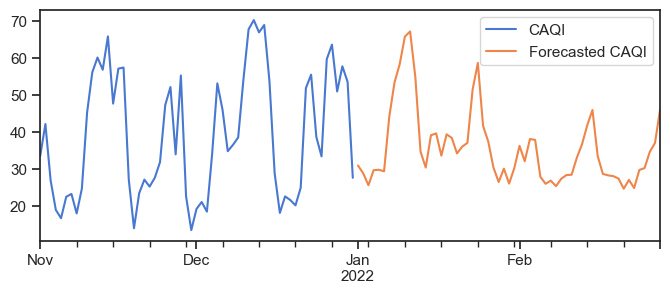

In [25]:
ax = warsaw_df.loc["2021-11-01" : "2021-12-31", "CAQI_idx"].plot(figsize=(8, 3), label="CAQI");
warsaw_df.loc["2022-01-01" : , "CAQI_idx"].plot(label="Forecasted CAQI", ax=ax);

ax.legend();

# Compare with actual CAQI

In [26]:
pollutant_df=\
pd.read_csv("datasets/Combined_pollutant_data_forecasting.csv", parse_dates=['DATE'], index_col='DATE')

pollutant_df.head()

,NO2,O3,PM10,PM25,powiat_voivod
DATE,,,,,
2022-01-01,11.554348,47.203261,15.333540,5.933913,"powiat warszawa, mazowieckie"
2022-01-02,14.889583,40.460417,11.352976,11.816667,"powiat warszawa, mazowieckie"
2022-01-03,20.019792,43.171875,10.525595,8.278333,"powiat warszawa, mazowieckie"
2022-01-04,31.255027,27.600000,14.016071,12.991667,"powiat warszawa, mazowieckie"
2022-01-05,25.662500,41.594792,11.952976,12.261667,"powiat warszawa, mazowieckie"


In [27]:
def find_CAQI(no_conc, o3_conc, pm10_conc, pm25_conc):
    
    default_indx_value=101;
    result_indx=dict();  

    caqi_index_levels_map= {1:[0,25],2:[25,50],3:[50,75],4:[75,100],5:[100,]}

    # Calculate NO2 sub-index and its level
    if not pd.isna(no_conc):
        if ((no_conc>=0) and (no_conc<=50)):
            target_indx=caqi_index_levels_map.get(1)
            no=np.interp(no_conc,[0,50],[target_indx[0],target_indx[1]])
        
        elif((no_conc>50) and (no_conc<=100)):
            target_indx=caqi_index_levels_map.get(2)
            no=np.interp(no_conc,[50,100],[target_indx[0],target_indx[1]])
            
        elif((no_conc>100) and (no_conc<=200)):  
            target_indx=caqi_index_levels_map.get(3)
            no=np.interp(no_conc,[100,200],[target_indx[0],target_indx[1]])
            
        elif((no_conc>200) and (no_conc<=400)):  
            target_indx=caqi_index_levels_map.get(4)
            no=np.interp(no_conc,[200,400],[target_indx[0],target_indx[1]])
            
        else:
            no=default_indx_value
    else:
        no=np.nan    

    result_indx['NO2_sub_idx'] = no
    
    # Calculate O3 sub-index
    if not pd.isna(o3_conc):
        if ((o3_conc>=0) and (o3_conc<=60)):
            target_indx=caqi_index_levels_map.get(1)
            o3=np.interp(o3_conc,[0,60],[target_indx[0],target_indx[1]])
        
        elif((o3_conc>60) and (o3_conc<=120)):
            target_indx=caqi_index_levels_map.get(2)
            o3=np.interp(o3_conc,[60,120],[target_indx[0],target_indx[1]])
        
        elif((o3_conc>120) and (o3_conc<=180)):  
            target_indx=caqi_index_levels_map.get(3)
            o3=np.interp(o3_conc,[120,180],[target_indx[0],target_indx[1]])
            
        elif((o3_conc>180) and (o3_conc<=240)):  
            target_indx=caqi_index_levels_map.get(4)
            o3=np.interp(o3_conc,[180,240],[target_indx[0],target_indx[1]])
        else:
            o3=default_indx_value
    else:
        o3=np.nan   

    result_indx['O3_sub_idx'] = o3      

    # Calculate PM10 sub-index
    if not pd.isna(pm10_conc):
        if ((pm10_conc>=0) and (pm10_conc<=25)):
            target_indx=caqi_index_levels_map.get(1)
            pm10=np.interp(pm10_conc,[0,25],[target_indx[0],target_indx[1]])
    
        elif((pm10_conc>25) and (pm10_conc<=50)):
            target_indx=caqi_index_levels_map.get(2)
            pm10=np.interp(pm10_conc,[25,50],[target_indx[0],target_indx[1]])
    
        elif((pm10_conc>50) and (pm10_conc<=90)):  
            target_indx=caqi_index_levels_map.get(3)
            pm10=np.interp(pm10_conc,[50,90],[target_indx[0],target_indx[1]])
    
        elif((pm10_conc>90) and (pm10_conc<=180)):  
            target_indx=caqi_index_levels_map.get(4)
            pm10=np.interp(pm10_conc,[90,180],[target_indx[0],target_indx[1]])
        
        else:
            pm10=default_indx_value
    else:
        pm10=np.nan

    result_indx['PM10_sub_idx'] = pm10
    
    # Calculate PM25 sub-index
    if not pd.isna(pm25_conc):
        if ((pm25_conc>=0) and (pm25_conc<=15)):
            target_indx=caqi_index_levels_map.get(1)
            pm25=np.interp(pm25_conc,[0,15],[target_indx[0],target_indx[1]])
    
        elif((pm25_conc>15) and (pm25_conc<=30)):
            target_indx=caqi_index_levels_map.get(2)
            pm25=np.interp(pm25_conc,[15,30],[target_indx[0],target_indx[1]])
    
        elif((pm25_conc>30) and (pm25_conc<=55)):  
            target_indx=caqi_index_levels_map.get(3)
            pm25=np.interp(pm25_conc,[30,55],[target_indx[0],target_indx[1]])
    
        elif((pm25_conc>55) and (pm25_conc<=110)):  
            target_indx=caqi_index_levels_map.get(4)
            pm25=np.interp(pm25_conc,[55,110],[target_indx[0],target_indx[1]])
        
        else:
            pm25=default_indx_value
    else:
        pm25=np.nan

    result_indx['PM25_sub_idx'] = pm25
    
    # Find poorest (highest) index value among available pollutats
    caqi_indx=np.nanmax(np.array([no, o3, pm10, pm25]))
    result_indx['CAQI_idx'] = caqi_indx  

    # Find CAQI index level
    if not pd.isna(caqi_indx):
        if ((caqi_indx>=0) and (caqi_indx<=25)):
            caqi='vlow'
        
        elif((caqi_indx>25) and (caqi_indx<=50)):
            caqi='low'
    
        elif((caqi_indx>50) and (caqi_indx<=75)):  
            caqi='medium'
    
        elif((caqi_indx>75) and (caqi_indx<=100)):  
            caqi='high'
        
        else:
            caqi='vhigh'
    else:
        caqi=''

    result_indx['CAQI_level'] = caqi  

    #print(caqi_indx)
    #print(caqi)

    return result_indx

In [28]:
def iterate_data_frame(df):
    for i, row in df.iterrows():
        if (pd.isna(row['NO2']) and pd.isna(row['O3']) and pd.isna(row['PM10']) and pd.isna(row['PM25'])):
            df.loc[i, 'CAQI_idx']=math.nan
            df.loc[i, 'CAQI_level']=''

        else:
            result=find_CAQI(row['NO2'], row['O3'], row['PM10'], row['PM25'])
            df.loc[i, 'NO2_sub_idx']=result['NO2_sub_idx']
            df.loc[i, 'O3_sub_idx']=result['O3_sub_idx']
            df.loc[i, 'PM10_sub_idx']=result['PM10_sub_idx']
            df.loc[i, 'PM25_sub_idx']=result['PM25_sub_idx']
            df.loc[i, 'CAQI_idx']=result['CAQI_idx']
            df.loc[i, 'CAQI_level']=result['CAQI_level']  

In [29]:
iterate_data_frame(df=pollutant_df)

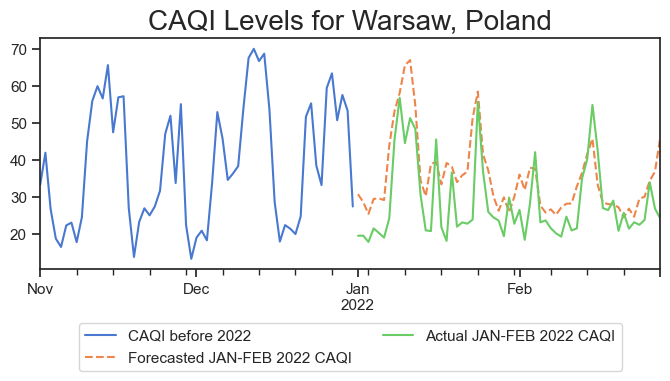

In [30]:
ax = warsaw_df.loc["2021-11-01" : "2021-12-31", "CAQI_idx"].plot(figsize=(8, 3));

warsaw_df.loc["2022-01-01" : , "CAQI_idx"].plot(ax=ax, linestyle="--");

pollutant_df['CAQI_idx'].plot(ax=ax);

ax.set_xlabel("")
ax.set_title("CAQI Levels for Warsaw, Poland")
ax.legend(labels=["CAQI before 2022", "Forecasted JAN-FEB 2022 CAQI", "Actual JAN-FEB 2022 CAQI"], ncol=2, 
          bbox_to_anchor=(0.95, -0.2));

In [31]:
rmse = mean_squared_error(pollutant_df['CAQI_idx'], 
                          warsaw_df.loc["2022-01-01" : , "CAQI_idx"], 
                          squared=False)

print(f"Actual vs Forecast CAQI RMSE: {rmse:3f}")

Actual vs Forecast CAQI RMSE: 10.091592
